Script for processing lake and inundated vegetation time series from Chang. Each Lake is in its own tab of an Excel spreadsheet with a row for each date observation. The script calculates statistics on each lake.

TODO: use ipython widgets to make a slider for each lake that plots the histogram

## Statistics:

Lake inundation area (open water + inundated vegetation)
min
max
std dev
25 and 75 percentile
mean
median
skewness
kurtosis
Some statistic based on the Inundation Frequency maps?

Lake inundation perimeter [lower priority]

Emergent vegetation area
min [lower priority]
max [lower priority]
std dev  [lower priority]
25 and 75 percentile [lower priority]
mean
median
skewness [lower priority]
kurtosis [lower priority]
Some statistic based on the Inundation Frequency maps? [lower priority]

Emergent/flooded vegetation fraction of total inundation (em_fraction)
min [lower priority]
max [lower priority]
std dev  [lower priority]
25 and 75 percentile [lower priority]
mean
median
skewness [lower priority]
kurtosis [lower priority]
Some statistic based on the Inundation Frequency maps? [lower priority]

In [12]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import qgrid
# import scipy as sp
from scipy import stats as sps

from pandas import DataFrame

In [2]:
## qgrid parameters
# for help, see https://qgrid.readthedocs.io/en/latest/ or https://github.com/quantopian/qgrid

## set defaults
grid_options = {
        # SlickGrid options
        'fullWidthRows': True, # True
        'syncColumnCellResize': True,
        'forceFitColumns': False, #True
        'defaultColumnWidth': 150, # 150
        'rowHeight': 28,
        'enableColumnReorder': True,
        'enableTextSelectionOnCells': True,
        'editable': True,
        'autoEdit': False,
        'explicitInitialization': True,

        # Qgrid options
        'maxVisibleRows': 10,
        'minVisibleRows': 4,
        'sortable': True,
        'filterable': True,
        'highlightSelectedCell': True,
        'highlightSelectedRow': True
    }

col_options = {
    # SlickGrid column options
    'defaultSortAsc': True,
    'maxWidth': None, # None,
    'minWidth': 30, #30
    'resizable': True,
    'sortable': True,
    'toolTip': "",
    'width': None, # None

    # Qgrid column options
    'editable': True,
}
qgrid.set_defaults(grid_options=grid_options, column_options=col_options)
qgrid.enable() #enable interactive pandas dataframes

In [18]:
    # PAD
# xlsx_path = '/mnt/f/PAD2019/ChangHuang/Lakes4Ethan-PAD-YF/ABOVE_coordinates_for_Chang_v1_working.xlsx'
# out_path = '/mnt/f/PAD2019/ChangHuang/Lakes4Ethan-PAD-YF/ek_out/time-series-stats-pad-yf.xlsx'
# out_plot_path = '/mnt/f/PAD2019/ChangHuang/Lakes4Ethan-PAD-YF/ek_out/total_inun_time_series-pad-yf.pdf'

    #YKN
# xlsx_path = '/mnt/f/PAD2019/ChangHuang/Yellowknife/ABOVE_coordinates for Ethan_12-01-20_all_em_fraction_average.xlsx'
# out_path = '/mnt/f/PAD2019/ChangHuang/ek_out/time-series-stats-yellowknife.xlsx'
# out_plot_path = '/mnt/f/PAD2019/ChangHuang/ek_out/total_inun_time_series-yellowknife.pdf'
    
    # YKN and Wekweeti
xlsx_path = '/mnt/f/PAD2019/ChangHuang/Wekweeti/ABOVE_coordinates for Ethan_12-01-20_all_em_fraction_average-Wekweeti-working.xlsx'
out_path = '/mnt/f/PAD2019/ChangHuang/ek_out/time-series-stats-yellowknife-wekweeti.xlsx'
out_plot_path = '/mnt/f/PAD2019/ChangHuang/ek_out/total_inun_time_series-yellowknife-wekweeti.pdf'

df = pd.read_excel(xlsx_path, sheet_name=None)
df.keys()

odict_keys(['ABOVE_coordinates for Ethan_12-', 'Tea 07-19-19', 'Mosquito 07-19-19', 'Guiness 07-19-19', 'Coffee 07-19-19', 'Backdoor 07-17-19', 'NW10 08-21-19', 'NE40 08-21-19', 'NE20 08-22-19', 'M1 08-19-19', 'Lake M2', 'H23 08-19-19', 'H21 08-19-19', 'H22 08-19-19', 'H20 08-19-19', 'Airport pond 08-20-19', 'Lake 10', 'NW20 08-21-19', 'NW40 08-21-19', 'NW30 08-21-19', 'NW80 08-21-19', 'NW70 08-21-19', 'NW60 08-21-19', 'NW50 08-21-19', 'CH6', 'LongLake'])

In [19]:
## create structure for results

stats=DataFrame(columns=['Lake'], index=None)
# stats.set_index('Lake')

In [14]:
## old version: for pad/yf
for i, lake in enumerate(df.keys()):
    if (lake != 'Lakes') & ~('ABOVE_coordinates' in lake):
        i-=1
        print(lake, end='\t')
        
            # init
        stats.loc[i, 'Lake']=lake
        df[lake]['Lake']=lake # not essential
        
            # total inundation (don't calc mean or med b/c geographic coord system...)
        df[lake]['total_inun']= df[lake].OpenWater + df[lake].FloatingMacrophyte + \
            df[lake].EmergentMacrophyte	+ df[lake].FloodedVegetation
        stats.loc[i, 'total_inun_std'] =  df[lake]['total_inun'].std()
        stats.loc[i, 'total_inun_mean_DONOTUSE'] =  df[lake]['total_inun'].mean()
        stats.loc[i, 'total_inun_skewness'] =  sps.skew(df[lake]['total_inun'])
        stats.loc[i, 'total_inun_kurtosis'] =  sps.kurtosis(df[lake]['total_inun'])
        stats.loc[i, 'total_inun_dyn_pct'] =  (df[lake]['total_inun'].max() - df[lake]['total_inun'].min()) / df[lake]['total_inun'].max() * 100 
        df[lake]['date_doy'] = df[lake].loc[:,'date'].dt.strftime('%j').astype('int')
        
        #
#         max_inun_idx=pd.Series.idxmax(df[lake]['total_inun'])
#         stats.loc[i, 'mean_inun_doy_max'] = df[lake]['date_doy'][max_inun_idx]
#         min_inun_idx=pd.Series.idxmin(df[lake]['total_inun'])
#         stats.loc[i, 'mean_inun_doy_min'] = df[lake]['date_doy'][min_inun_idx]
        
        #
        
        group_by_year=df[lake].groupby(df[lake]['date'].dt.year)
        min_inun_idx=group_by_year['total_inun'].idxmin()
        max_inun_idx=group_by_year['total_inun'].idxmax()
        stats.loc[i, 'mean_inun_doy_min'] = df[lake].date_doy[min_inun_idx].mean()
        stats.loc[i, 'mean_inun_doy_max'] = df[lake].date_doy[max_inun_idx].mean()
        
            # em
        df[lake]['inun_veg']= df[lake].FloatingMacrophyte + \
            df[lake].EmergentMacrophyte	+ df[lake].FloodedVegetation
        stats.loc[i, 'em_std']=df[lake]['inun_veg'].std()
        stats.loc[i, 'em_skewness']=sps.skew(df[lake]['inun_veg'])
        stats.loc[i, 'em_kurtosis']=sps.kurtosis(df[lake]['inun_veg'])
        
            # em_fraction
        stats.loc[i, 'em_fraction_mean']=df[lake]['em_fraction[(C+D+E)/(B+C+D+E)]'].mean()
        stats.loc[i, 'em_fraction_med']=df[lake]['em_fraction[(C+D+E)/(B+C+D+E)]'].median()
        stats.loc[i, 'em_fraction_min']=df[lake]['em_fraction[(C+D+E)/(B+C+D+E)]'].min()
        stats.loc[i, 'em_fraction_max']=df[lake]['em_fraction[(C+D+E)/(B+C+D+E)]'].max()
        stats.loc[i, 'em_fraction_std']=df[lake]['em_fraction[(C+D+E)/(B+C+D+E)]'].std()
        stats.loc[i, 'em_fraction_skewness']=sps.skew(df[lake]['inun_veg'])
        stats.loc[i, 'em_fraction_kurtosis']=sps.kurtosis(df[lake]['inun_veg'])

## display result
stats        

Tea 07-19-19	

KeyError: 'em_fraction[(C+D+E)/(B+C+D+E)]'

In [28]:
## Wekweeti

for i, lake in enumerate(df.keys()):
    if (lake != 'Lakes') & ~('ABOVE_coordinates' in lake):
        i-=1
        print(lake, end='\t')
        
            # init
        stats.loc[i, 'Lake']=lake
        df[lake]['Lake']=lake # not essential
        
            # drop na
        df[lake].dropna(inplace=True)
        
            # total inundation (don't calc mean or med b/c geographic coord system...)
        df[lake]['total_inun']= df[lake].OpenWater + df[lake].FloatingMacrophyte + \
            df[lake].EmergentMacrophyte	+ df[lake].FloodedVegetation
        stats.loc[i, 'total_inun_std'] =  df[lake]['total_inun'].std()
        stats.loc[i, 'total_inun_mean_DONOTUSE'] =  df[lake]['total_inun'].mean()
        stats.loc[i, 'total_inun_skewness'] =  sps.skew(df[lake]['total_inun'])
        stats.loc[i, 'total_inun_kurtosis'] =  sps.kurtosis(df[lake]['total_inun'])
        stats.loc[i, 'total_inun_dyn_pct'] =  (df[lake]['total_inun'].max() - df[lake]['total_inun'].min()) / df[lake]['total_inun'].max() * 100 
        df[lake]['date_doy'] = df[lake].loc[:,'date'].dt.strftime('%j').astype('int')
        
        #
#         max_inun_idx=pd.Series.idxmax(df[lake]['total_inun'])
#         stats.loc[i, 'mean_inun_doy_max'] = df[lake]['date_doy'][max_inun_idx]
#         min_inun_idx=pd.Series.idxmin(df[lake]['total_inun'])
#         stats.loc[i, 'mean_inun_doy_min'] = df[lake]['date_doy'][min_inun_idx]
        
        #
        
        group_by_year=df[lake].groupby(df[lake]['date'].dt.year)
        min_inun_idx=group_by_year['total_inun'].idxmin()
        max_inun_idx=group_by_year['total_inun'].idxmax()
        stats.loc[i, 'mean_inun_doy_min'] = df[lake].date_doy[min_inun_idx].mean()
        stats.loc[i, 'mean_inun_doy_max'] = df[lake].date_doy[max_inun_idx].mean()
        
            # em
        df[lake]['inun_veg']= df[lake].FloatingMacrophyte + \
            df[lake].EmergentMacrophyte	+ df[lake].FloodedVegetation
        stats.loc[i, 'em_std']=df[lake]['inun_veg'].std()
        stats.loc[i, 'em_skewness']=sps.skew(df[lake]['inun_veg'])
        stats.loc[i, 'em_kurtosis']=sps.kurtosis(df[lake]['inun_veg'])
        
            # em_fraction
        stats.loc[i, 'em_fraction_mean']=df[lake]['em_fraction'].mean()
        stats.loc[i, 'em_fraction_med']=df[lake]['em_fraction'].median()
        stats.loc[i, 'em_fraction_min']=df[lake]['em_fraction'].min()
        stats.loc[i, 'em_fraction_max']=df[lake]['em_fraction'].max()
        stats.loc[i, 'em_fraction_std']=df[lake]['em_fraction'].std()
        stats.loc[i, 'em_fraction_skewness']=sps.skew(df[lake]['inun_veg'])
        stats.loc[i, 'em_fraction_kurtosis']=sps.kurtosis(df[lake]['inun_veg'])

## display result
stats        

Tea 07-19-19	Mosquito 07-19-19	Guiness 07-19-19	Coffee 07-19-19	Backdoor 07-17-19	NW10 08-21-19	NE40 08-21-19	NE20 08-22-19	M1 08-19-19	Lake M2	H23 08-19-19	H21 08-19-19	H22 08-19-19	H20 08-19-19	Airport pond 08-20-19	Lake 10	NW20 08-21-19	NW40 08-21-19	NW30 08-21-19	NW80 08-21-19	NW70 08-21-19	NW60 08-21-19	NW50 08-21-19	CH6	LongLake	

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [29]:
## save result

stats.to_excel(out_path, freeze_panes=(1,2))

# Testing

In [30]:
## Does max inun come first? (if so, negative val)
comp=stats.loc[:, 'mean_inun_doy_max'] - stats.loc[:, 'mean_inun_doy_min']
print(f'{np.sum(comp<0)} out of {len(comp)} lakes Max inundation occurs before min')
print(comp)
stats.loc[:, ['mean_inun_doy_min','mean_inun_doy_max']]

16 out of 25 lakes Max inundation occurs before min
0     -52.0
1     -44.0
2     -24.0
3     -80.0
4     -12.0
5      20.0
6     104.0
7     -36.0
8      88.0
9      20.0
10    -76.0
11    -96.0
12     64.0
13    -96.0
14     72.0
15     12.0
16     28.0
17   -116.0
18    -56.0
19   -120.0
20   -100.0
21    -12.0
22    -92.0
23      0.0
24    -68.0
dtype: float64


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

/home/ekyzivat/miniconda2/envs/geohackw/lib/python3.7/site-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

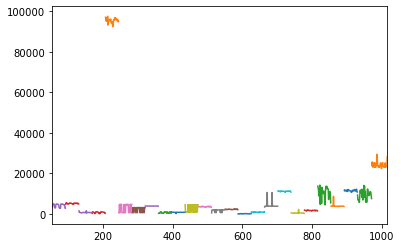

In [31]:
## Plot hydrographs!

megadf = pd.DataFrame()
for i, lake in enumerate(df.keys()):
    if lake != 'Lakes':
        megadf=megadf.append(df[lake], ignore_index=True)
megadf
megadf.groupby('Lake').total_inun.plot()

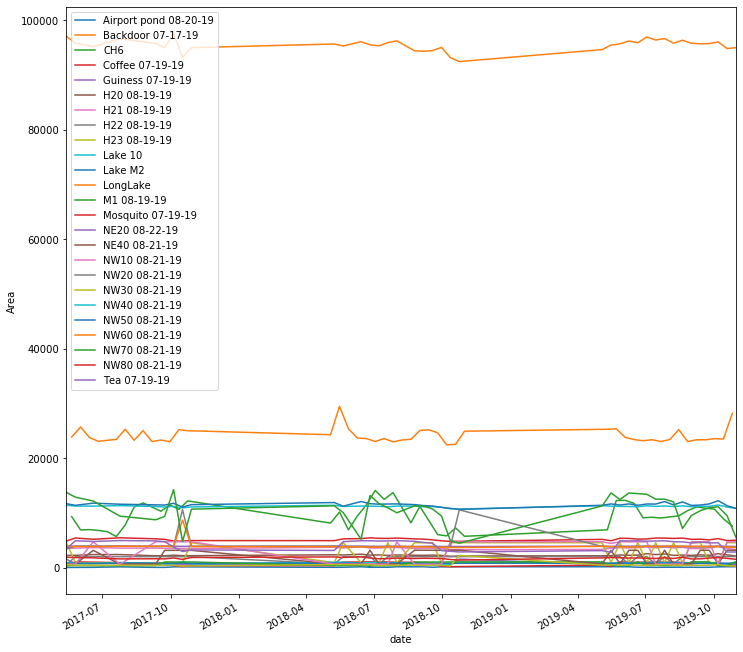

In [34]:
## Plots!
# to do: improve planning by making three side-by-side plots with the intervening winter months removed. Or add breaks in the X axis.

fig, ax=plt.subplots(figsize=(12,12))
magdf_grp=megadf.groupby('Lake')
# magdf_grp.plot(x='date', y='total_inun') #, title=megadf.groupby('Lake').groups.keys(), subplots=True) # make indiv plots with no title
for name, group in magdf_grp:
    magdf_grp.get_group(name).plot(x='date', y='total_inun', ax=ax, label=name) #, title=megadf.groupby('Lake').groups.keys(), subplots=True)

ax.set_ylabel('Area')
## save
fig.savefig( out_plot_path, dpi=300)

In [33]:
megadf

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [345]:
magdf_grp.get_group('yf20')
magdf_grp.get_group(name)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [319]:
megadf.groupby('Lake').Lake

# Scrap

In [103]:
## Scrap to test std dev effect from magnitude : answer: no effect!

print(np.std([10, 9, 10, 10, 10, 9, 10, 10]))
print(np.std(100+np.array([10, 9, 10, 10, 10, 9, 10, 10])))

0.4330127018922193
0.4330127018922193


In [193]:
## scrap to test new stats
df[lake] #['total_inun']
pd.to_datetime(df[lake].loc[:, 'date']) # unnecessary, bc already a datetime!
df[lake].dtypes

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [241]:
## group by year
# df['BallonLake']['year']=df['BallonLake'].loc[:, 'date'].dt.strftime('%Y')
# df['BallonLake']['year']
# df['BallonLake'].groupby('year')
df['BallonLake'].groupby(df['BallonLake']['date'].dt.year)
# max_inun_idx=
# pd.Series.idxmax(df['BallonLake'].groupby('year')['total_inun'])
# df['BallonLake'].groupby('year')['total_inun'].apply()
# df['BallonLake'].groupby(df['BallonLake']['date'].dt.year)['total_inun'].aggregate('np.argmin')

max_inun_idx=df['BallonLake'].groupby(df['BallonLake']['date'].dt.year)['total_inun'].idxmax()
print(max_inun_idx)
min_inun_idx=df['BallonLake'].groupby(df['BallonLake']['date'].dt.year)['total_inun'].idxmin()
print(min_inun_idx)
df['BallonLake'].groupby(df['BallonLake']['date'].dt.year).date_doy.nth(8)
# stats.loc[i, 'mean_inun_doy_max'] = df[lake]['date_doy'][max_inun_idx]
# stats.loc[i, 'mean_inun_doy_max'] 
# dir(df['BallonLake'].groupby(df['BallonLake']['date'].dt.year)['total_inun'])

date
2017     0
2018    16
2019    28
Name: total_inun, dtype: int64
date
2017     6
2018    23
2019    40
Name: total_inun, dtype: int64


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [331]:
df['BallonLake'].groupby(df['BallonLake']['date'].dt.year).date_doy.nth(8)
df['BallonLake'].groupby(df['BallonLake']['date'].dt.year).date_doy.indices[2018]
# df['BallonLake'].groupby(df['BallonLake']['date'].dt.year).date_doy.get_group('name')
df['BallonLake'].groupby(df['BallonLake']['date'].dt.year).date_doy.ngroup()
df['BallonLake'].groupby(df['BallonLake']['date'].dt.year).date_doy.head(2)
type(df['BallonLake'].groupby(df['BallonLake']['date'].dt.year).date_doy.nth([0,1]))
df['BallonLake'].groupby(df['BallonLake']['date'].dt.year).date_doy.groups
df['BallonLake'].groupby(df['BallonLake']['date'].dt.year).date_doy.indices
# df['BallonLake'].groupby(df['BallonLake']['date'].dt.year).date_doy.get_group(2018)
df['BallonLake'].groupby(df['BallonLake']['date'].dt.year).FloodedVegetation.max()
list(df['BallonLake'].groupby(df['BallonLake']['date'].dt.year).date_doy.groups.keys())

[2017, 2018, 2019]

In [283]:
## try loop

group_by_year=df['BallonLake'].groupby(df['BallonLake']['date'].dt.year)
min_inun_idx=group_by_year['total_inun'].idxmin()
max_inun_idx=group_by_year['total_inun'].idxmax()

for j,k in enumerate(group_by_year.indices): # iterate over keys, which is year
    df['BallonLake'].groupby(df['BallonLake']['date'].dt.year).date_doy.get_group(k)
min_inun_idx
max_inun_idx

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [288]:
## found non-loop way!
group_by_year=df['BallonLake'].groupby(df['BallonLake']['date'].dt.year)
min_inun_idx=group_by_year['total_inun'].idxmin()
max_inun_idx=group_by_year['total_inun'].idxmax()
df['BallonLake'].date_doy[min_inun_idx].mean()

260.0

In [217]:
?pd.DataFrame.apply

Signature:
pd.DataFrame.apply(
    self,
    func,
    axis=0,
    broadcast=None,
    raw=False,
    reduce=None,
    result_type=None,
    args=(),
    **kwds,
)
Docstring:
Apply a function along an axis of the DataFrame.

Objects passed to the function are Series objects whose index is
either the DataFrame's index (``axis=0``) or the DataFrame's columns
(``axis=1``). By default (``result_type=None``), the final return type
is inferred from the return type of the applied function. Otherwise,
it depends on the `result_type` argument.

Parameters
----------
func : function
    Function to apply to each column or row.
axis : {0 or 'index', 1 or 'columns'}, default 0
    Axis along which the function is applied:

    * 0 or 'index': apply function to each column.
    * 1 or 'columns': apply function to each row.
broadcast : bool, optional
    Only relevant for aggregation functions:

    * ``False`` or ``None`` : returns a Series whose length is the
      length of the index or the numbe